# Connect to OPeNDAP

A. Stein 11.18.21, updated 1.6.22, updated 3.2.22

"""    
Here is a tutorial on how to use OPeNDAP to get at data on the THREDDS server at NKN (Univeristy of Idaho): https://climate.northwestknowledge.net/MACA/OPENDAP.php

There are a couple of places on the THREDDS server where there are drought indicators: 
-	[CIRC Drought folder](http://thredds.northwestknowledge.net:8080/thredds/catalog/DROUGHT_LAYERS/catalog.html): VEGDRI, USDM, QUICKDRI, MCDI, LERI, GRACE, FDSI, ESI
-	[GRIDMET DROUGHT indicators](http://thredds.northwestknowledge.net:8080/thredds/reacch_climate_MET_aggregated_catalog.html): SPI/SPEI/EDDI at different timescales (these are in the Drought Stripes tool)
-	VIC DROUGHT indicators: I'm currently making these from the WUSA/CONUS datasets for SRI (standardized runoff index), SM/TM/SWE percentiles
    -	[WUSA](http://thredds.northwestknowledge.net:8080/thredds/catalog/VIC_UCLA/VIC-WUSA/catalog.html)-  there's going to be some new files soon that all the daily data in a single file
    -	[CONUS](http://thredds.northwestknowledge.net:8080/thredds/catalog/VIC_UCLA/VIC-CONUS/catalog.html) - there's going to be some new files soon that all the daily data in a single file

There's also another resource you should be aware of that might help:    
-	[Climate Engine](https://app.climateengine.com/climateEngine)    
    -	USDM raster data over CONUS: there is a rasterized version of the USDM drought classification over CONUS that might be useful to pull a time series from for a point location. I'm looking to put this full raster data on THREDDS at some point soon.. just need some time to aggregate the files. 
    -	Standardized NDVI or  percentiles in NDVI from remote sensing (MODIS or Landsat) might be useful here for vegetation drought.  
      
""" - K. Hegewisch

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import xarray as xr
import pandas as pd
from netCDF4 import Dataset
from tqdm.autonotebook import tqdm

import geopandas as gpd

dirPath = 'http://thredds.northwestknowledge.net:8080/thredds/dodsC'
cwd = '/pool0/home/steinadi/data/drought/drought_impact/data'

Populating the interactive namespace from numpy and matplotlib


/pool0/data/steinadi/.conda/envs/sedi/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  if __name__ == '__main__':


In [2]:
file = 'DROUGHT_LAYERS/VEGDRI/vegdri_20201011.nc'
sample = xr.open_dataset(f"{dirPath}/{file}")
sample

<xarray.Dataset>
Dimensions:  (lat: 2687, lon: 5791)
Coordinates:
  * lat      (lat) float64 51.77 51.75 51.74 51.73 ... 22.51 22.5 22.49 22.48
  * lon      (lon) float64 -128.5 -128.5 -128.5 -128.5 ... -65.42 -65.41 -65.4
Data variables:
    vegdri   (lat, lon) float64 ...

Awesome, so we have access. We unfortunately can't do `open_mfdataset` and us a wildcard, so will have to get a bit more creative ...

## VEGDRI

In [3]:
sample['vegdri']

<xarray.DataArray 'vegdri' (lat: 2687, lon: 5791)>
[15560417 values with dtype=float64]
Coordinates:
  * lat      (lat) float64 51.77 51.75 51.74 51.73 ... 22.51 22.5 22.49 22.48
  * lon      (lon) float64 -128.5 -128.5 -128.5 -128.5 ... -65.42 -65.41 -65.4
Attributes:
    description:    VegDRI data provided by USGS as their web site https://ed...
    long_name:      vegdri
    standard_name:  vegdri
    units:          %
    _ChunkSizes:    [448 966]

In [4]:
# looks like VEGDRI is weekly from 2019-03-10 to 2020-10-11
vegdri_dates = pd.date_range('2019-03-10','2020-10-11', freq='W')#.strftime("%Y%m%d")

vegdri = xr.Dataset(
    coords = dict(
        lat = sample['lat'].values,
        lon = sample['lon'].values,
        time = vegdri_dates
    ),
    data_vars = dict(
        vegdri=(['lat','lon','time'], np.empty((len(sample['lat'].values), len(sample['lon'].values), len(vegdri_dates))) * np.nan)
    )
)
vegdri

<xarray.Dataset>
Dimensions:  (lat: 2687, lon: 5791, time: 84)
Coordinates:
  * lat      (lat) float64 51.77 51.75 51.74 51.73 ... 22.51 22.5 22.49 22.48
  * lon      (lon) float64 -128.5 -128.5 -128.5 -128.5 ... -65.42 -65.41 -65.4
  * time     (time) datetime64[ns] 2019-03-10 2019-03-17 ... 2020-10-11
Data variables:
    vegdri   (lat, lon, time) float64 nan nan nan nan nan ... nan nan nan nan

In [5]:
loop = tqdm(vegdri_dates)
for date in loop:
    loop.set_description(date.strftime('%Y-%m-%d'))
    # using try-except in case there are holes in the data
    try:
        vegdri['vegdri'].loc[{'time':date}] = xr.open_dataset(f"{dirPath}/DROUGHT_LAYERS/VEGDRI/vegdri_{date.strftime('%Y%m%d')}.nc")['vegdri'].values
    except:
        pass

  0%|          | 0/84 [00:00<?, ?it/s]

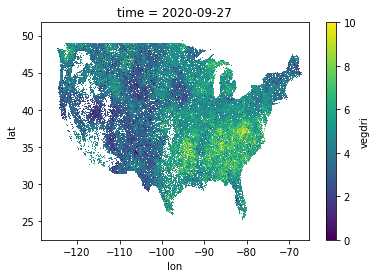

In [6]:
# now since this is lat/lon data, it will appear as nan when just glancing at the dataset view, 
# but if we plot it we can see we were successful
vegdri['vegdri'].isel(time=81).plot()

In [7]:
vegdri['vegdri'].attrs = sample['vegdri'].attrs

vegdri['vegdri']

<xarray.DataArray 'vegdri' (lat: 2687, lon: 5791, time: 84)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * lat      (lat) float64 51.77 51.75 51.74 51.73 ... 22.51 22.5 22.49 22.48
  * lon      (lon) float64 -128.5 -128.5 -128.5 -128.5 ... -65.42 -65.41 -65.4
  * time     (time) datetime64[ns] 2019-03-10 2019-03-17 ... 2020-10-11
Attributes:
    description:    VegDRI data provided by USGS as their web site https://ed...
    long_name:      vegdri
    standard_name:  vegdri
    units:          %
    _ChunkSizes:    [448 966]

In [8]:
vegdri.to_netcdf(f"{cwd}/vegdri.nc")

## MCDI

In [9]:
# ah ha! thanks Katherine for already compiling these wrt time
MCDI = xr.open_mfdataset([f"{dirPath}/DROUGHT_LAYERS/MCDI/SM_fraction_swe.nc", f"{dirPath}/DROUGHT_LAYERS/MCDI/SM_fraction.nc"])
MCDI

<xarray.Dataset>
Dimensions:          (time: 1522, lon: 464, lat: 200)
Coordinates:
  * time             (time) datetime64[ns] 1895-01-15 1895-02-15 ... 2021-10-15
  * lon              (lon) float64 -124.9 -124.8 -124.7 ... -67.31 -67.19 -67.06
  * lat              (lat) float64 49.94 49.81 49.69 49.56 ... 25.31 25.19 25.06
Data variables:
    SM_fraction      (time, lat, lon) float32 dask.array<chunksize=(1522, 200, 464), meta=np.ndarray>
    SM_fraction_swe  (time, lat, lon) float32 dask.array<chunksize=(1522, 200, 464), meta=np.ndarray>

In [10]:
MCDI.to_netcdf(f"{cwd}/mcdi.nc")

## LERI

In [11]:
leri_sample =  xr.open_dataset(f"{dirPath}/DROUGHT_LAYERS/LERI/leri_2021-10.nc")
leri_sample['leri']

<xarray.DataArray 'leri' (lat: 2844, lon: 6617)>
[18818748 values with dtype=float64]
Coordinates:
  * lat      (lat) float64 49.54 49.53 49.52 49.51 ... 23.98 23.97 23.96 23.95
  * lon      (lon) float64 -126.0 -126.0 -126.0 -126.0 ... -66.48 -66.47 -66.46
Attributes:
    description:    Percentiles of Landscape Evaporative Response Index (LERI...
    long_name:      leri
    standard_name:  leri
    units:          %
    _ChunkSizes:    [ 474 1103]

In [12]:
# alright, LERI is by month from 2015-01 to 2021-10
leri_dates = pd.date_range('2015-01', '2021-10', freq='MS').strftime('%Y-%m')

leri = xr.Dataset(
    coords = dict(
        lat = leri_sample['lat'].values,
        lon = leri_sample['lon'].values,
        time = leri_dates
    ),
    data_vars = dict(
        leri=(['lat','lon','time'], np.empty((len(leri_sample['lat'].values), len(leri_sample['lon'].values), len(leri_dates))) * np.nan)
    )
)
leri

<xarray.Dataset>
Dimensions:  (lat: 2844, lon: 6617, time: 82)
Coordinates:
  * lat      (lat) float64 49.54 49.53 49.52 49.51 ... 23.98 23.97 23.96 23.95
  * lon      (lon) float64 -126.0 -126.0 -126.0 -126.0 ... -66.48 -66.47 -66.46
  * time     (time) object '2015-01' '2015-02' '2015-03' ... '2021-09' '2021-10'
Data variables:
    leri     (lat, lon, time) float64 nan nan nan nan nan ... nan nan nan nan

In [13]:
loop = tqdm(leri_dates)
for date in loop:
    loop.set_description(date)
    # using try-except in case there are holes in the data
    try:
        leri['leri'].loc[{'time':date}] = xr.open_dataset(f"{dirPath}/DROUGHT_LAYERS/LERI/leri_{date}.nc")['leri'].values
    except:
        pass

  0%|          | 0/82 [00:00<?, ?it/s]

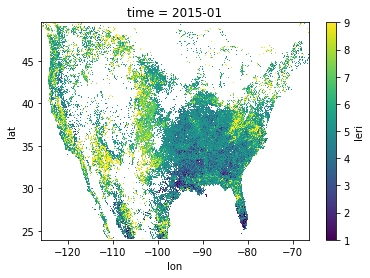

In [14]:
leri['leri'].isel(time=0).plot()

In [15]:
leri['leri'].attrs = leri_sample['leri'].attrs

In [16]:
leri.to_netcdf(f"{cwd}/leri.nc")

## GRACE

In [2]:
grace_sample = xr.open_dataset(f"{dirPath}/DROUGHT_LAYERS/GRACE/GRACEsfsm_20211108.nc")
grace_sample['GRACEsfsm']

<xarray.DataArray 'GRACEsfsm' (lat: 224, lon: 464)>
[103936 values with dtype=float64]
Coordinates:
  * lat      (lat) float64 25.06 25.19 25.31 25.44 ... 52.56 52.69 52.81 52.94
  * lon      (lon) float64 -124.9 -124.8 -124.7 -124.6 ... -67.31 -67.19 -67.06
Attributes:
    description:    Percentiles of GRACE-Based percentiles of surface soil mo...
    long_name:      GRACEsfsm
    standard_name:  GRACEsfsm
    units:          %
    _ChunkSizes:    [224 464]

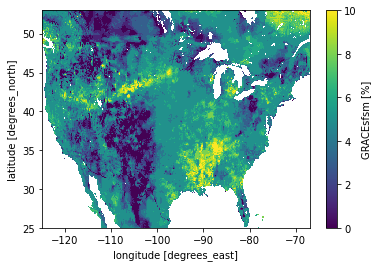

In [3]:
grace_sample['GRACEsfsm'].plot()

It looks like there is 

- `GRACEsfsm` from 20140113 to 20211108 (weekly)
- `GRACErtzsm` from 20140113 to 20211108 (weekly)
- `GRACEgws` from 20140113 to 20211108(weekly)

Looking at the [website](https://nasagrace.unl.edu/Default.aspx), these look like they correspond to the following datasets:

- GRACEsfsm = Surface Soil Moisture Percentile
- GRACErtzsm = Root Zone Soil Moisture Percentile
- GRACEgws = groundwater percentile

In [16]:
grace_dates = pd.date_range('2014-01-13', '2021-11-08', freq='W-MON')

empty = np.empty((len(grace_sample['lat'].values), len(grace_sample['lon'].values), len(grace_dates))) * np.nan

grace = xr.Dataset(
    coords = dict(
        lat = grace_sample['lat'].values,
        lon = grace_sample['lon'].values,
        time = grace_dates
    ),
    data_vars = dict(
        GRACEsfsm=(['lat','lon','time'], empty),
        GRACErtzsm=(['lat','lon','time'], empty),
        GRACEgws=(['lat','lon','time'], empty),
    )
)

In [17]:
loop = tqdm(grace_dates)
for date in loop:
    simp_date = date.strftime('%Y%m%d')
    loop.set_description(str(date))
    # using try-except in case there are holes in the data
    for var in ['GRACEsfsm','GRACErtzsm','GRACEgws']:
        try:
            grace[var].loc[{'time':date}] = xr.open_dataset(f"{dirPath}/DROUGHT_LAYERS/GRACE/{var}_{simp_date}.nc")[var].values
        except:
            pass

  0%|          | 0/409 [00:00<?, ?it/s]

In [18]:
attrs = xr.open_dataset(f"{dirPath}/DROUGHT_LAYERS/GRACE/{var}_20211108.nc")[var].attrs

for var in ['GRACEsfsm','GRACErtzsm','GRACEgws']:
    grace[var].attrs = attrs

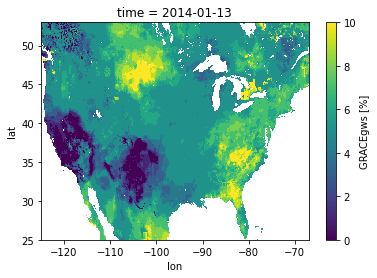

In [19]:
grace['GRACEsfsm'].isel(time=0).plot()

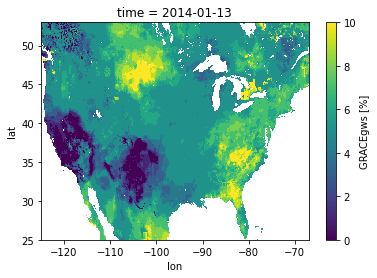

In [20]:
grace['GRACErtzsm'].isel(time=0).plot()

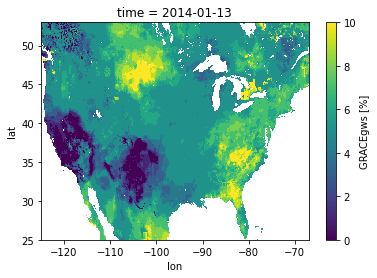

In [21]:
grace['GRACEsfsm'].isel(time=0).plot()

In [22]:
grace.to_netcdf('../data/drought_measures/grace.nc')

Ah-ha! It works now! For future reference, below is debugging the dates.

well that's simply not working, need to debug (fixed)

grace_dates

date = grace_dates[0].strftime('%Y%m%d')
date

Oh well that's simply not the right date to start with, should be `20140113`. So it's not working cause it's getting the dates wrong ... or at least that's my first hypothesis.

pd.date_range('2014-01-13', '2021-11-08', freq='W-MON')

That looks to have fixed it, it was counting from Sundays whereas we need to count from Mondays (ugh, business week). Going to adjust that above and rerun

## FDSI

In [24]:
# this is good to go, will just save it for local access
xr.open_dataset(f"{dirPath}/DROUGHT_LAYERS/FDSI/FDSI_CONUS_1980-2020_GRIDMET.nc").to_netcdf(f'{cwd}/fdsi.nc')

## ESI

this one would probably be good to have, but I need to ask more what the 4week and 12week are ...

ah, it's the time period that is considered in calculating it

"The 4-wk ESI takes into accound the evaporative stress of the last 4-weeks. The 12-week ESI takes into account the evaporative stress of the last 12-weeks. These are the time scales on which the data has been aggregated.. similar to how the SPI 1-month looks at the last 1-month of precipitation, while SPI 2-year looks at the last 1-year of precipitation." - K. Hegewisch

In [2]:
xr.open_dataset(f"{dirPath}/DROUGHT_LAYERS/ESI/esi_4wk.nc")

<xarray.Dataset>
Dimensions:  (lat: 499, time: 228, lon: 1157)
Coordinates:
  * lat      (lat) float64 24.52 24.57 24.62 24.67 ... 49.27 49.32 49.37 49.42
  * time     (time) object 2000-12-31 00:00:00 ... 2019-11-30 00:00:00
  * lon      (lon) float64 -124.8 -124.7 -124.7 -124.6 ... -67.08 -67.03 -66.97
Data variables:
    esi      (lat, lon, time) float64 ...

Hm, there is some more recent data but I don't *need* it right now, so will just use the nice and compiled netCDF's for now.

In [3]:
xr.open_dataset(f"{dirPath}/DROUGHT_LAYERS/ESI/esi_4wk.nc").to_netcdf(f'{cwd}/esi_4wk.nc')

In [4]:
xr.open_dataset(f"{dirPath}/DROUGHT_LAYERS/ESI/esi_12wk.nc").to_netcdf(f'{cwd}/esi_12wk.nc')

# Drought Stripes Data from OPeNDAP

http://thredds.northwestknowledge.net:8080/thredds/reacch_climate_MET_catalog.html

In [2]:
dirPath_met = 'http://thredds.northwestknowledge.net:8080/thredds/dodsC/MET'

## SPI

temp = xr.open_dataset(f'{dirPath_met}/spi/spi90d.nc')

try:
    os.remove(f'{cwd}/spi90d.nc')
except:
    pass

temp.to_netcdf(f'{cwd}/spi90d.nc')

## PDSI

In [13]:
pdsi = xr.open_dataset(f'{dirPath_met}/pdsi/pdsi.nc')#.to_netcdf(f'{cwd}/pdsi.nc')

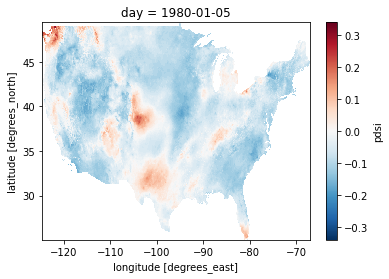

In [17]:
pdsi['pdsi'].isel(day=0).plot()

So it seems like there is some sort of in saving the size of the file? Dunno ... let's try saving without xarray and just use bash?

In [2]:
xr.open_dataset(f'{cwd}/pdsi.nc')

<xarray.Dataset>
Dimensions:  (lon: 1386, lat: 585, day: 3066, crs: 1)
Coordinates:
  * lon      (lon) float64 -124.8 -124.7 -124.7 -124.6 ... -67.14 -67.1 -67.06
  * lat      (lat) float64 49.4 49.36 49.32 49.28 ... 25.19 25.15 25.11 25.07
  * day      (day) datetime64[ns] 1980-01-05 1980-01-10 ... 2021-12-31
  * crs      (crs) uint16 3
Data variables:
    pdsi     (day, lat, lon) float32 ...
Attributes: (12/23)
    geospatial_bounds_crs:      EPSG:4326
    Conventions:                CF-1.6
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_lat_min:         25.066666666666666
    geospatial_lat_max:         49.40000000000000
    geospatial_lon_min:         -124.7666666333333
    ...                         ...
    last_permanent_slice:       3006
    last_early_slice:           3066
    last_provisional_slice:     3060
    note3:                      Data in slices after last_permanent_slice (1-...
    note4:                      Data in slices after last_provisional_slice (...
    note5:                      Days correspond approximately to calendar day...

Ay, that worked using `wget` in bash, we'll do that for the rest of these

## EDDI

## SPEI

# Met Data from OPeNDAP

Lastly I need to gather meteorological data. I think the following will suffice:
- precipitation
    - how wet it is outside might impact if folks do outdoor activities
- max/min relative humidity and specific humidity
    - this might influence comfort?
- min/max air temperature
    - have seen this impact visitation in other places
- wind direction and wind speed
    - would you want to go rafting or skiing when it's really windy out?
- burning index
    - more fire metrics might help

I don't currently think that Fuel Moisture or Energy Release Component will help more than fire danger ratings.

In [2]:
met_path = f'{cwd}/met'
print(met_path)

thredds_met = 'http://thredds.northwestknowledge.net:8080/thredds/dodsC'
print(thredds_met)

/pool0/home/steinadi/data/drought/drought_impact/data/met
http://thredds.northwestknowledge.net:8080/thredds/dodsC


In [3]:
path = f'{thredds_met}/MET/pr/pr_2022.nc'
print(path)
precip = xr.open_dataset(path)
precip

http://thredds.northwestknowledge.net:8080/thredds/dodsC/MET/pr/pr_2022.nc


<xarray.Dataset>
Dimensions:               (lat: 585, day: 61, crs: 1, lon: 1386)
Coordinates:
  * lat                   (lat) float64 49.4 49.36 49.32 ... 25.15 25.11 25.07
  * day                   (day) datetime64[ns] 2022-01-01 ... 2022-03-02
  * crs                   (crs) float32 3.0
  * lon                   (lon) float64 -124.8 -124.7 -124.7 ... -67.1 -67.06
Data variables:
    precipitation_amount  (day, lat, lon) float32 ...
Attributes: (12/22)
    geospatial_bounds_crs:      EPSG:4326
    Conventions:                CF-1.6
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_lat_min:         25.066666666666666
    geospatial_lat_max:         49.40000000000000
    geospatial_lon_min:         -124.7666666333333
    ...                         ...
    last_permanent_slice:       1
    last_early_slice:           61
    last_provisional_slice:     55
    note3:                      Data in slices after last_permanent_slice (1-...
    note4:                      Data in slices after last_provisional_slice (...
    note5:                      Days correspond approximately to calendar day...

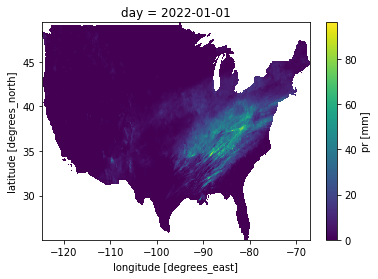

In [4]:
precip['precipitation_amount'].isel(day=0).plot()

So that works, and it saves out alright. Let's have fun looping

In [5]:
met_var = ('pr', 'rmin', 'rmax', 'sph', 'th', 'vs' 'tmmn', 'tmmx', 'bi')
met_name = ('precip', 'rh_min', 'rh_max', 'sph', 'wind_dir', 'wind_spd', 'tair_min', 'tair_max', 'burn_idx')
years = np.arange(1979, 2023, 1)

In [6]:
precip = xr.open_mfdataset(paths=[f'{thredds_met}/MET/pr/pr_{year}.nc' for year in years])
precip

<xarray.Dataset>
Dimensions:               (lat: 585, lon: 1386, crs: 1, day: 15767)
Coordinates:
  * lat                   (lat) float64 49.4 49.36 49.32 ... 25.15 25.11 25.07
  * lon                   (lon) float64 -124.8 -124.7 -124.7 ... -67.1 -67.06
  * crs                   (crs) float32 3.0
  * day                   (day) datetime64[ns] 1979-01-01 ... 2022-03-02
Data variables:
    precipitation_amount  (day, lat, lon) float32 dask.array<chunksize=(365, 585, 1386), meta=np.ndarray>
Attributes: (12/19)
    geospatial_bounds_crs:      EPSG:4326
    Conventions:                CF-1.6
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_lat_min:         25.066666666666666
    geospatial_lat_max:         49.40000000000000
    geospatial_lon_min:         -124.7666666333333
    ...                         ...
    date:                       02 July 2019
    note1:                      The projection information for this file is: ...
    note2:                      Citation: Abatzoglou, J.T., 2013, Development...
    note3:                      Data in slices after last_permanent_slice (1-...
    note4:                      Data in slices after last_provisional_slice (...
    note5:                      Days correspond approximately to calendar day...

I'm going to put this into a bash script so I can run it on tmux and not worry about my notebook doing anything strange

Let's now checkout some data

In [7]:
met_path = '../../data/met'

In [8]:
xr.open_mfdataset(f'{met_path}/precip/*')

<xarray.Dataset>
Dimensions:               (lon: 1386, lat: 585, day: 15766, crs: 1)
Coordinates:
  * lon                   (lon) float64 -124.8 -124.7 -124.7 ... -67.1 -67.06
  * lat                   (lat) float64 49.4 49.36 49.32 ... 25.15 25.11 25.07
  * day                   (day) datetime64[ns] 1979-01-01 ... 2022-03-01
  * crs                   (crs) uint16 3
Data variables:
    precipitation_amount  (day, lat, lon) float32 dask.array<chunksize=(365, 585, 1386), meta=np.ndarray>
Attributes: (12/19)
    geospatial_bounds_crs:      EPSG:4326
    Conventions:                CF-1.6
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_lat_min:         25.066666666666666
    geospatial_lat_max:         49.40000000000000
    geospatial_lon_min:         -124.7666666333333
    ...                         ...
    date:                       02 July 2019
    note1:                      The projection information for this file is: ...
    note2:                      Citation: Abatzoglou, J.T., 2013, Development...
    note3:                      Data in slices after last_permanent_slice (1-...
    note4:                      Data in slices after last_provisional_slice (...
    note5:                      Days correspond approximately to calendar day...

In [9]:
xr.open_mfdataset(f'{met_path}/rh_max/*')

<xarray.Dataset>
Dimensions:            (lon: 1386, lat: 585, day: 15766, crs: 1)
Coordinates:
  * lon                (lon) float64 -124.8 -124.7 -124.7 ... -67.1 -67.06
  * lat                (lat) float64 49.4 49.36 49.32 ... 25.15 25.11 25.07
  * day                (day) datetime64[ns] 1979-01-01 1979-01-02 ... 2022-03-01
  * crs                (crs) uint16 3
Data variables:
    relative_humidity  (day, lat, lon) float32 dask.array<chunksize=(365, 585, 1386), meta=np.ndarray>
Attributes: (12/19)
    geospatial_bounds_crs:      EPSG:4326
    Conventions:                CF-1.6
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_lat_min:         25.066666666666666
    geospatial_lat_max:         49.40000000000000
    geospatial_lon_min:         -124.7666666333333
    ...                         ...
    date:                       02 July 2019
    note1:                      The projection information for this file is: ...
    note2:                      Citation: Abatzoglou, J.T., 2013, Development...
    note3:                      Data in slices after last_permanent_slice (1-...
    note4:                      Data in slices after last_provisional_slice (...
    note5:                      Days correspond approximately to calendar day...

In [10]:
xr.open_mfdataset(f'{met_path}/rh_min/*')

<xarray.Dataset>
Dimensions:            (lon: 1386, lat: 585, day: 15766, crs: 1)
Coordinates:
  * lon                (lon) float64 -124.8 -124.7 -124.7 ... -67.1 -67.06
  * lat                (lat) float64 49.4 49.36 49.32 ... 25.15 25.11 25.07
  * day                (day) datetime64[ns] 1979-01-01 1979-01-02 ... 2022-03-01
  * crs                (crs) uint16 3
Data variables:
    relative_humidity  (day, lat, lon) float32 dask.array<chunksize=(365, 585, 1386), meta=np.ndarray>
Attributes: (12/19)
    geospatial_bounds_crs:      EPSG:4326
    Conventions:                CF-1.6
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_lat_min:         25.066666666666666
    geospatial_lat_max:         49.40000000000000
    geospatial_lon_min:         -124.7666666333333
    ...                         ...
    date:                       02 July 2019
    note1:                      The projection information for this file is: ...
    note2:                      Citation: Abatzoglou, J.T., 2013, Development...
    note3:                      Data in slices after last_permanent_slice (1-...
    note4:                      Data in slices after last_provisional_slice (...
    note5:                      Days correspond approximately to calendar day...

In [11]:
xr.open_mfdataset(f'{met_path}/sph/*')

<xarray.Dataset>
Dimensions:            (lon: 1386, lat: 585, day: 15767, crs: 1)
Coordinates:
  * lon                (lon) float64 -124.8 -124.7 -124.7 ... -67.1 -67.06
  * lat                (lat) float64 49.4 49.36 49.32 ... 25.15 25.11 25.07
  * day                (day) datetime64[ns] 1979-01-01 1979-01-02 ... 2022-03-02
  * crs                (crs) uint16 3
Data variables:
    specific_humidity  (day, lat, lon) float32 dask.array<chunksize=(365, 585, 1386), meta=np.ndarray>
Attributes: (12/19)
    geospatial_bounds_crs:      EPSG:4326
    Conventions:                CF-1.6
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_lat_min:         25.066666666666666
    geospatial_lat_max:         49.40000000000000
    geospatial_lon_min:         -124.7666666333333
    ...                         ...
    date:                       02 July 2019
    note1:                      The projection information for this file is: ...
    note2:                      Citation: Abatzoglou, J.T., 2013, Development...
    note3:                      Data in slices after last_permanent_slice (1-...
    note4:                      Data in slices after last_provisional_slice (...
    note5:                      Days correspond approximately to calendar day...

In [12]:
xr.open_mfdataset(f'{met_path}/tair_max/*')

<xarray.Dataset>
Dimensions:          (lon: 1386, lat: 585, day: 15767, crs: 1)
Coordinates:
  * lon              (lon) float64 -124.8 -124.7 -124.7 ... -67.14 -67.1 -67.06
  * lat              (lat) float64 49.4 49.36 49.32 49.28 ... 25.15 25.11 25.07
  * day              (day) datetime64[ns] 1979-01-01 1979-01-02 ... 2022-03-02
  * crs              (crs) uint16 3
Data variables:
    air_temperature  (day, lat, lon) float32 dask.array<chunksize=(365, 585, 1386), meta=np.ndarray>
Attributes: (12/19)
    geospatial_bounds_crs:      EPSG:4326
    Conventions:                CF-1.6
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_lat_min:         25.066666666666666
    geospatial_lat_max:         49.40000000000000
    geospatial_lon_min:         -124.7666666333333
    ...                         ...
    date:                       02 July 2019
    note1:                      The projection information for this file is: ...
    note2:                      Citation: Abatzoglou, J.T., 2013, Development...
    note3:                      Data in slices after last_permanent_slice (1-...
    note4:                      Data in slices after last_provisional_slice (...
    note5:                      Days correspond approximately to calendar day...

In [13]:
xr.open_mfdataset(f'{met_path}/tair_min/*')

<xarray.Dataset>
Dimensions:          (lon: 1386, lat: 585, day: 15767, crs: 1)
Coordinates:
  * lon              (lon) float64 -124.8 -124.7 -124.7 ... -67.14 -67.1 -67.06
  * lat              (lat) float64 49.4 49.36 49.32 49.28 ... 25.15 25.11 25.07
  * day              (day) datetime64[ns] 1979-01-01 1979-01-02 ... 2022-03-02
  * crs              (crs) uint16 3
Data variables:
    air_temperature  (day, lat, lon) float32 dask.array<chunksize=(365, 585, 1386), meta=np.ndarray>
Attributes: (12/19)
    geospatial_bounds_crs:      EPSG:4326
    Conventions:                CF-1.6
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_lat_min:         25.066666666666666
    geospatial_lat_max:         49.40000000000000
    geospatial_lon_min:         -124.7666666333333
    ...                         ...
    date:                       02 July 2019
    note1:                      The projection information for this file is: ...
    note2:                      Citation: Abatzoglou, J.T., 2013, Development...
    note3:                      Data in slices after last_permanent_slice (1-...
    note4:                      Data in slices after last_provisional_slice (...
    note5:                      Days correspond approximately to calendar day...

In [15]:
xr.open_mfdataset(f'{met_path}/wind_dir/*')

<xarray.Dataset>
Dimensions:              (lon: 1386, lat: 585, day: 15767, crs: 1)
Coordinates:
  * lon                  (lon) float64 -124.8 -124.7 -124.7 ... -67.1 -67.06
  * lat                  (lat) float64 49.4 49.36 49.32 ... 25.15 25.11 25.07
  * day                  (day) datetime64[ns] 1979-01-01 ... 2022-03-02
  * crs                  (crs) uint16 3
Data variables:
    wind_from_direction  (day, lat, lon) float32 dask.array<chunksize=(365, 585, 1386), meta=np.ndarray>
Attributes: (12/19)
    geospatial_bounds_crs:      EPSG:4326
    Conventions:                CF-1.6
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_lat_min:         25.066666666666666
    geospatial_lat_max:         49.40000000000000
    geospatial_lon_min:         -124.7666666333333
    ...                         ...
    date:                       02 July 2019
    note1:                      The projection information for this file is: ...
    note2:                      Citation: Abatzoglou, J.T., 2013, Development...
    note3:                      Data in slices after last_permanent_slice (1-...
    note4:                      Data in slices after last_provisional_slice (...
    note5:                      Days correspond approximately to calendar day...

In [17]:
xr.open_mfdataset(f'{met_path}/wind_spd/*')

<xarray.Dataset>
Dimensions:     (lon: 1386, lat: 585, day: 15767, crs: 1)
Coordinates:
  * lon         (lon) float64 -124.8 -124.7 -124.7 ... -67.14 -67.1 -67.06
  * lat         (lat) float64 49.4 49.36 49.32 49.28 ... 25.19 25.15 25.11 25.07
  * day         (day) datetime64[ns] 1979-01-01 1979-01-02 ... 2022-03-02
  * crs         (crs) uint16 3
Data variables:
    wind_speed  (day, lat, lon) float32 dask.array<chunksize=(365, 585, 1386), meta=np.ndarray>
Attributes: (12/19)
    geospatial_bounds_crs:      EPSG:4326
    Conventions:                CF-1.6
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_lat_min:         25.066666666666666
    geospatial_lat_max:         49.40000000000000
    geospatial_lon_min:         -124.7666666333333
    ...                         ...
    date:                       02 July 2019
    note1:                      The projection information for this file is: ...
    note2:                      Citation: Abatzoglou, J.T., 2013, Development...
    note3:                      Data in slices after last_permanent_slice (1-...
    note4:                      Data in slices after last_provisional_slice (...
    note5:                      Days correspond approximately to calendar day...

In [19]:
xr.open_mfdataset(f'{met_path}/burn_idx/*')

<xarray.Dataset>
Dimensions:          (lon: 1386, lat: 585, day: 15767, crs: 1)
Coordinates:
  * lon              (lon) float64 -124.8 -124.7 -124.7 ... -67.14 -67.1 -67.06
  * lat              (lat) float64 49.4 49.36 49.32 49.28 ... 25.15 25.11 25.07
  * day              (day) datetime64[ns] 1979-01-01 1979-01-02 ... 2022-03-02
  * crs              (crs) uint16 3
Data variables:
    burning_index_g  (day, lat, lon) float32 dask.array<chunksize=(365, 585, 1386), meta=np.ndarray>
Attributes: (12/19)
    geospatial_bounds_crs:      EPSG:4326
    Conventions:                CF-1.6
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_lat_min:         25.066666666666666
    geospatial_lat_max:         49.40000000000000
    geospatial_lon_min:         -124.7666666333333
    ...                         ...
    date:                       02 July 2019
    note1:                      The projection information for this file is: ...
    note2:                      Citation: Abatzoglou, J.T., 2013, Development...
    note3:                      Data in slices after last_permanent_slice (1-...
    note4:                      Data in slices after last_provisional_slice (...
    note5:                      Days correspond approximately to calendar day...

Wonderful, they all open fine. Now to organize them in `organize_data/clip_met_data.ipynb`